In [1]:
import pickle
import matplotlib.pyplot as plt

In [2]:
history = pickle.load(open('./models/classification_oben_history.hdf5', "rb"))

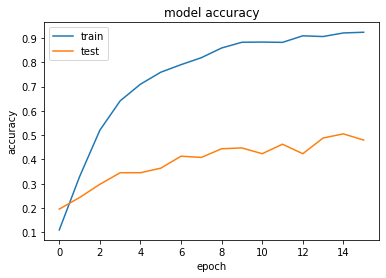

In [3]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()